# 1 - Introduction

There is not a lot of code required, but we are going to step over it slowly so that you will know how to create your own models in the future. The steps you are going to cover in this practical assignment are as follows:

1. Load Data
2. Define Model
3. Compile Model
4. Fit Model
5. Evaluate Model
6. Tie It All Together
7. Make Predictions

## Import packages

In [ ]:
!pip install mlxtend==0.17.3

     |████████████████████████████████| 1.3MB 2.8MB/s 
  Found existing installation: mlxtend 0.17.2
    Uninstalling mlxtend-0.17.2:
      Successfully uninstalled mlxtend-0.17.2


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import time
from mlxtend.plotting import plot_decision_regions


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
tf.__version__

'2.3.0'

## Import dataset

In [ ]:
def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X']
    train_Y = data['y']
    test_X = data['Xval']
    test_Y = data['yval']

    plt.scatter(train_X[:,0], train_X[:,1], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

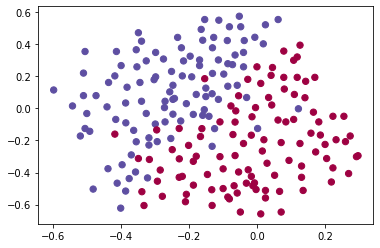

In [ ]:
train_x, train_y, test_x, test_y = load_2D_dataset()

In [ ]:
print("Shape\nTrain_x: {0} \t Train_y: {1}\nTest_x: {2} \t Test_y: {3}\n".format(train_x.shape,train_y.shape,test_x.shape,test_y.shape))

Shape
Train_x: (211, 2) 	 Train_y: (211, 1)
Test_x: (200, 2) 	 Test_y: (200, 1)



# 2 - Non-Regularized Model

Now, define a simple custom callback to track the start and end of train. Reference [here](https://github.com/keras-team/keras-io/blob/master/tf/custom_callback.ipynb).

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(self.begins))

  def on_train_end(self, logs=None):
    print('Evaluating: ends at {}'.format(time.time() - self.begins))

In [ ]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation=tf.nn.relu),
                             tf.keras.layers.Dense(3, activation=tf.nn.relu),
                             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
                             ])

# Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 1598787981.2546947
Evaluating: ends at 25.200621366500854


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


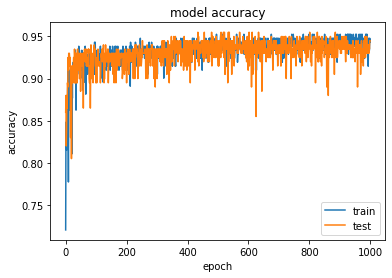

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

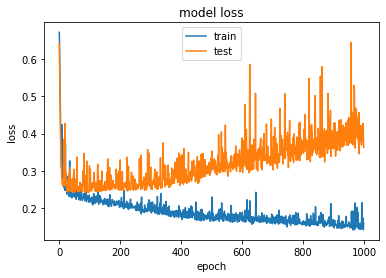

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

7/7 [==============================] - 0s 2ms/step - loss: 0.1556 - binary_accuracy: 0.9289
Train loss: 0.156 - acc: 0.929
7/7 [==============================] - 0s 1ms/step - loss: 0.3631 - binary_accuracy: 0.9450
Test loss: 0.363 - acc: 0.945


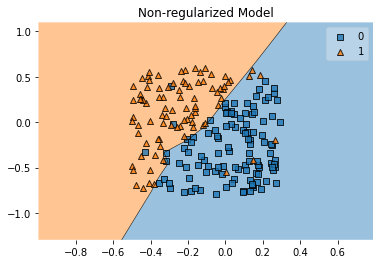

In [ ]:
from mlxtend.plotting import plot_decision_regions
# Plot decision boundary
plot_decision_regions(test_x,test_y.squeeze(), clf=model,zoom_factor=2.0)
plt.title("Non-regularized Model")
plt.show()

<mark><b>Exercise</b></mark>

- What happen when the batch_size is changed to <font color="red">train_x.shape[0]</font>?
- What is the impact on training time when changing the runtime type from <font color="red">CPU to GPU</font>?
- Change the CustomCallBack in order to support <font color="red">Datetime type</font> instead of <font color="red">Time type</font>.


In [ ]:
# PUT YOUR CODE HERE

# 3 - L2 Regularization



The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \left( \small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \right) \tag{1}$$

$$
a^{[L](i)} == \hat{y}^{(i)}
$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$


In [ ]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model_l2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation=tf.nn.relu),
                             tf.keras.layers.Dense(3, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
                             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
                             ])

# Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)

# configure the optimizer, loss, and metrics to monitor.
model_l2.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history_l2 = model_l2.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 1598788028.489277
Evaluating: ends at 24.92667579650879


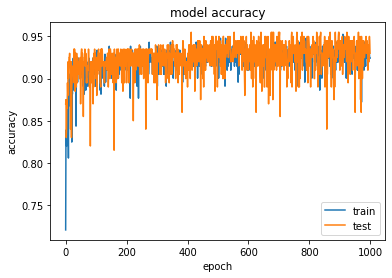

In [ ]:
# summarize history for accuracy
plt.plot(history_l2.history['binary_accuracy'])
plt.plot(history_l2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

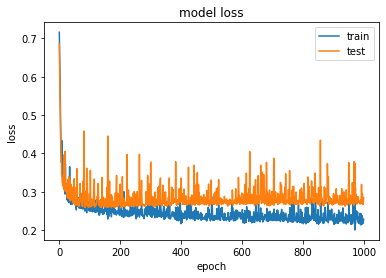

In [ ]:
# summarize history for loss
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
loss, acc = model_l2.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model_l2.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

7/7 [==============================] - 0s 2ms/step - loss: 0.2197 - binary_accuracy: 0.9384
Train loss: 0.220 - acc: 0.938
7/7 [==============================] - 0s 1ms/step - loss: 0.2843 - binary_accuracy: 0.9300
Test loss: 0.284 - acc: 0.930


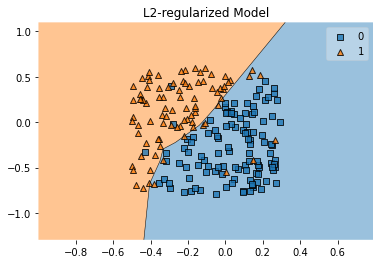

In [ ]:
from mlxtend.plotting import plot_decision_regions
# Plot decision boundary
plot_decision_regions(test_x,test_y.squeeze(), clf=model_l2,zoom_factor=2.0)
plt.title("L2-regularized Model")
plt.show()

<mark><b>Exercise</b></mark>

- Change the value of **L2** to [0.70,0.1,0.01,0.001] and analyze the results.
- Configure two first hidden layers with L2 regularization and investigate the results. 


In [ ]:
# PUT YOUR CODE HERE

# 4 - Dropout



Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** Watch these two animations to see what this means!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1eNMeI3JkcXQ3_AeOUItFfgf8D6tSexg0"></center>
<br>
<caption><center> <b>Figure 1</b>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1GfLbHLOQ2xzsDOQZ-d4m0ZmljZeBHAOz"></center>
<caption><center> <b>Figure 2</b>: Drop-out on the first and third hidden layers. <br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </center></caption>


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 


In [ ]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model_dropout = tf.keras.Sequential([
                             tf.keras.layers.Dense(20, activation=tf.nn.relu),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(3, activation=tf.nn.relu),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
                             ])

# Instantiate a logistic loss function that expects integer targets (binary classification 0 or 1)
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)

# configure the optimizer, loss, and metrics to monitor.
model_dropout.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history_dropout = model_dropout.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 1598788224.9021752
Evaluating: ends at 25.30732011795044


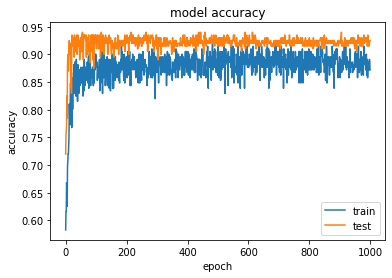

In [ ]:
# summarize history for accuracy
plt.plot(history_dropout.history['binary_accuracy'])
plt.plot(history_dropout.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

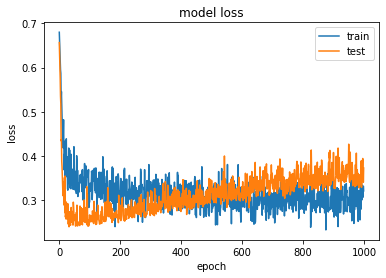

In [ ]:
# summarize history for loss
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
loss, acc = model_dropout.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model_dropout.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

7/7 [==============================] - 0s 1ms/step - loss: 0.1926 - binary_accuracy: 0.9336
Train loss: 0.193 - acc: 0.934
7/7 [==============================] - 0s 1ms/step - loss: 0.3723 - binary_accuracy: 0.9250
Test loss: 0.372 - acc: 0.925


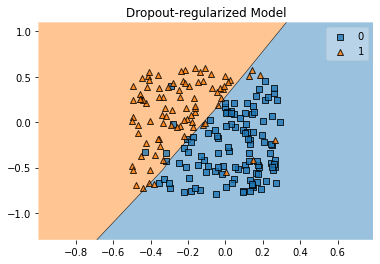

In [ ]:
from mlxtend.plotting import plot_decision_regions
# Plot decision boundary
plot_decision_regions(test_x,test_y.squeeze(), clf=model_dropout,zoom_factor=2.0)
plt.title("Dropout-regularized Model")
plt.show()

<mark><b>Exercise</b></mark>

- Evaluate different dropout configurations and try to understanding the influence of values adopted. 


In [ ]:
# PUT YOUR CODE HERE

# 4 - All together

In [ ]:
def print_analysis(titles,history,loss=True):
  if loss:
    func = "loss"
    func_val = "val_loss"
  else:
    func = "binary_accuracy"
    func_val = "val_binary_accuracy"

  f, axs = plt.subplots(1,len(titles),figsize=(12,6))
   
  for i, title in enumerate(titles):
    axs[i].set_title(title)
    axs[i].plot(history[i].history[func])
    axs[i].plot(history[i].history[func_val])
    axs[i].set_ylabel(func)
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')
  
  plt.tight_layout()
  plt.show()

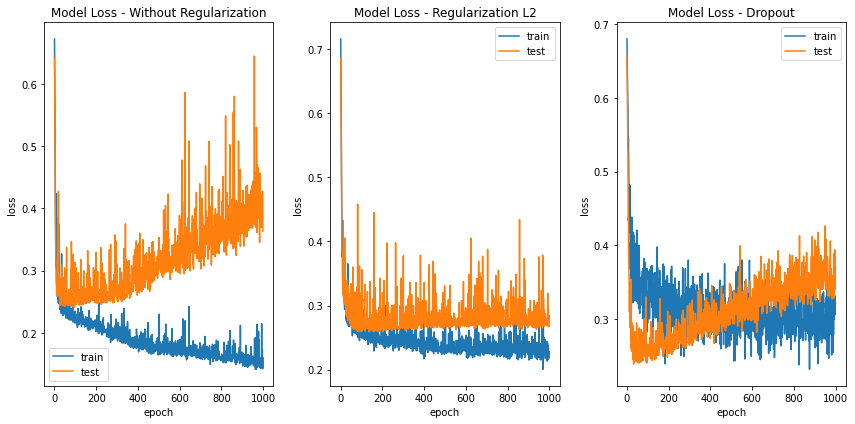

In [ ]:
titles = ['Model Loss - Without Regularization','Model Loss - Regularization L2','Model Loss - Dropout']
hist = [history,history_l2,history_dropout]
print_analysis(titles,hist,loss=True)

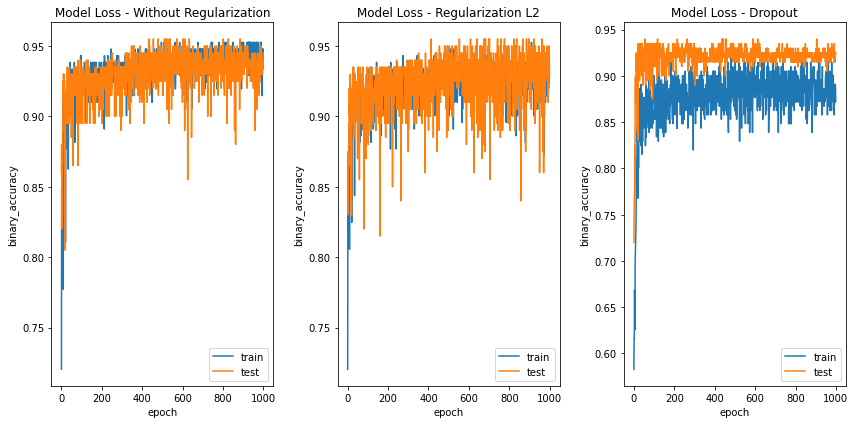

In [ ]:
print_analysis(titles,hist,loss=False)

In [ ]:
def print_regions(titles,models):

  f, axs = plt.subplots(1,len(titles),figsize=(12,6))
   
  for i, title in enumerate(titles):
    plot_decision_regions(test_x,test_y.squeeze(), clf=models[i],zoom_factor=2.0,ax=axs[i])
    axs[i].set_title(title)
  plt.tight_layout()
  plt.show()

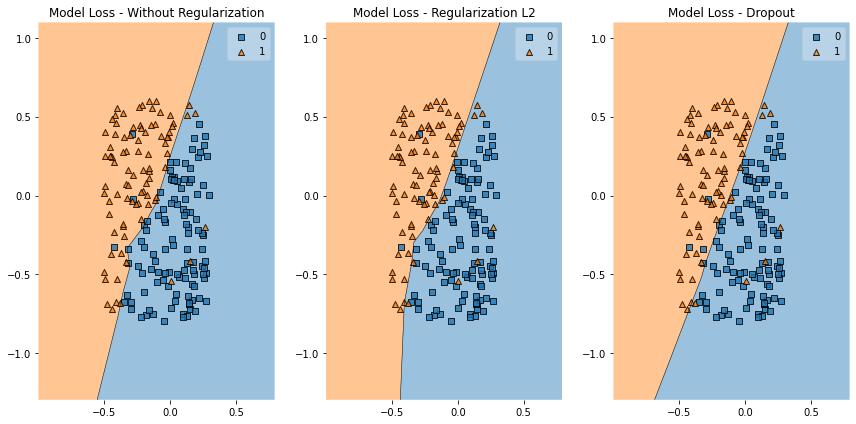

In [ ]:
models = [model,model_l2,model_dropout]
print_regions(titles,models)